In [53]:
# import packages 
import awkward as ak
import pandas as pd
import numpy as np
import re
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import matplotlib.pyplot as plt
from matplotlib_venn import venn2_unweighted
from matplotlib_venn import venn3, venn3_unweighted, venn3_circles

# 1) Import DMRs for all comparisons 

In [54]:
def read_methylscore(input_file)->ak.Array:
    """Read the filtered output methylscore into an akward array"""
    # Reading data from the input file and converting it to an awkward array
    array = []
    with open(input_file, 'r') as file:
        for line in file:
            columns = line.strip().split('\t')  # Split the line into columns
            array.append(columns)
    return ak.from_iter(array)

In [55]:
# Dictionary to store dmr_subset with their names
dmr_subsets = {}

# create an input file dict 
input_files = {'NvsA': '6_DMRsCG/1_NvsA/NvsA.txt', 'NvsR': '6_DMRsCG/2_NvsR/NvsR.txt', 'AvsR': '6_DMRsCG/3_AvsR/AvsR.txt'}

# Process each input file
for input_file in input_files.values():
    df = read_methylscore(input_file)

    # Extract column 1, 2, 3
    dmr_subset = df[:, [0, 1, 2]]

    # Convert to pandas dataframe
    dmr_subset = pd.DataFrame(dmr_subset)
    dmr_subset.rename(columns={0: 'chr', 1: 'start', 2: 'end'}, inplace=True)

    # Convert to int
    dmr_subset['start'] = dmr_subset['start'].astype(int)
    dmr_subset['end'] = dmr_subset['end'].astype(int)
    dmr_subset['chr'] = dmr_subset['chr'].astype(str)

    # Assign the name to dmr_subset
    subset_name = os.path.basename(os.path.dirname(input_file)).split('_')[-1] 
    dmr_subsets[subset_name] = dmr_subset


# 2) Import gene annotation

In [56]:
# import ccar_annotation.gtf as pd df 
import pandas as pd 

annotation = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/carcar_annotation_v5.gtf', sep='\t', comment='#', header=None)
# renaming the header of the annotation file
annotation = annotation.rename({0: 'seqname',
                                1: 'source',
                                2: 'feature',
                                3: 'start',
                                4: 'stop',
                                5: 'score',
                                6: 'strand',
                                7: 'frame',
                                8: 'attribute'}, axis=1)

    
# define a function to extract the geneid
def extract_gene_id(attributes):
    # Using a regular expression to match and extract the desired part
    match = re.search(r'gene_id "([^"]+)"', attributes)
    if match:
        return match.group(1)
    else:
        return 0 # Return 0 if there is no match
    
# filtering the column feature for transcritps
annotation = annotation[annotation['feature'] == 'transcript']

# Apply the function to the "attributes" column and create a new column with the extracted gene ids
annotation['gene_id'] = annotation['attribute'].apply(extract_gene_id)

# DEDUPLICATE 
# since a gene has multiple transcripts you have to deduplicate the geneids 
# calculate trascript length 
annotation['length'] = annotation['stop'] - annotation['start']
# sort annotation for geneid and transcript length (length is sorted ascending) 
annotation = annotation.sort_values(['gene_id','length'])
# deduplicate to keep the gene id with the longest transcript length 
annotation = annotation.drop_duplicates(subset=['gene_id'], keep='last')

# 3) Add 5% bp to start and stop of gene id's to simulate UTRs (untranslated regions) 

In [57]:
# extract seqname , start and stop column 
annotation = annotation[['seqname', 'start', 'stop', 'gene_id', 'length']]
# create new column called "start_5" (decrease the start value about 5% of the gene length (in bp) to include promotor sequences)
annotation['start_5'] = (annotation['start'] - (annotation['length'] * 0.05)).astype(int)
# check if any value is negative and replace it with 0
annotation['start_5'] = np.where(annotation['start_5'] < 0, 0, annotation['start_5'])
# create new column called "stop_5" (increase the stop value by 5% of the gene length (in bp) to include ploy AAA tales)
annotation['stop_5'] = (annotation['stop'] + (annotation['length'] * 0.05)).astype(int)

# 4) Identify if DMR is within gene borders --> append geneid to list 

In [58]:

# define function to append relevant information to dmrs
def append_info(dmr_df:pd.DataFrame, index:int, annotation:pd.DataFrame, list_to_append:list)->None:
    """Append relevant information of one row to the list_to_append.
    
    Parameters:
    -----------
    dmr_df: pd.DataFrame
        The dataframe containing the DMRs.
    index: int
        The index of the DMR to append.
    annotation: pd.DataFrame
        The dataframe containing the relvant line of the annotation."""
    line = pd.DataFrame(dmr_df.loc[index]).T            
    line['gene_id'] = annotation['gene_id'].values[0]
    line['start_5'] = annotation['start_5'].values[0]
    line['stop_5'] = annotation['stop_5'].values[0]
    line['start_0'] = annotation['start'].values[0]
    line['stop_0'] = annotation['stop'].values[0]
    list_to_append.append(line)


dmr_withinGeneBorder = {}

for subset_name, dmr_subset in dmr_subsets.items():
    temp = [] # list if dmrs hit more than 1 gene id 
    for index, row in dmr_subset.iterrows():
        relevant_annotation = annotation[(annotation['seqname'] == row['chr']) & (annotation['start_5'] <= row['start']) & (annotation['stop_5'] >= row['end'])]
        if len(relevant_annotation) == 1:
            append_info(dmr_subset, index, relevant_annotation, temp)
        elif len(relevant_annotation) > 1: # if a dmr hits more gene ids 
            for i,line in relevant_annotation.iterrows():
                append_info(dmr_subset, index, pd.DataFrame(line).T, temp)
    dmr_withinGeneBorder[subset_name] = pd.concat(temp)

In [59]:
# export the dataframes to csv files
dmr_withinGeneBorder['NvsA'].to_csv('7_match_dmr_to_gene/dmr_within_geneborders/dmr_withinGeneBorder_NvsA.csv', sep=',', index=False)
dmr_withinGeneBorder['NvsR'].to_csv('7_match_dmr_to_gene/dmr_within_geneborders/dmr_withinGeneBorder_NvsR.csv', sep=',', index=False)
dmr_withinGeneBorder['AvsR'].to_csv('7_match_dmr_to_gene/dmr_within_geneborders/dmr_withinGeneBorder_AvsR.csv', sep=',', index=False)

In [60]:
# select unique geneids from the dmr_withinGeneBorder output
geneid_unique = {}
for name,df in dmr_withinGeneBorder.items():
    geneid_unique[name] = df['gene_id'].unique().tolist()
# export list of unique geneids to json file
with open(f'7_match_dmr_to_gene/dmr_within_geneborders_genelist/dmr_unique_geneids.json', 'w') as file:
    json.dump(geneid_unique, file)
# export list of unique geneids to csv file 
pd.DataFrame(geneid_unique['NvsA']).rename(columns={0:'geneid'}).to_csv('7_match_dmr_to_gene/dmr_within_geneborders_genelist/dmr_withinGeneBorder_NvsA_geneids.csv', sep=',', index=False)
pd.DataFrame(geneid_unique['NvsR']).rename(columns={0:'geneid'}).to_csv('7_match_dmr_to_gene/dmr_within_geneborders_genelist/dmr_withinGeneBorder_NvsR_geneids.csv', sep=',', index=False)
pd.DataFrame(geneid_unique['AvsR']).rename(columns={0:'geneid'}).to_csv('7_match_dmr_to_gene/dmr_within_geneborders_genelist/dmr_withinGeneBorder_AvsR_geneids.csv', sep=',', index=False)

# 5 Venn diagram: overlapping DMR geneids 

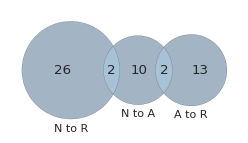

In [61]:
# Venn diagram of overlapping DMRs within gene borders
sns.set_theme(style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})
plt.figure(figsize=(7.5/2.54, 4.25/2.54))
v = venn3([set(geneid_unique['NvsA']), 
           set(geneid_unique['NvsR']), 
           set(geneid_unique['AvsR'])], 
           set_labels=('N to A', 'N to R', 'A to R'), 
           set_colors=("#1A4870", "#1A4870", "#1A4870"))
# plt.title('Differentially Methylated Genes')
for text in v.set_labels:
    text.set_fontsize(8)
venn3_circles([set(geneid_unique['NvsA']), 
           set(geneid_unique['NvsR']), 
           set(geneid_unique['AvsR'])], 
           linewidth=0.1, color='black')

plt.savefig('7_match_dmr_to_gene/venn_dmr_withinGeneBorder_overlapping.svg')

In [62]:
# check how many dmrs are within gene borders. 
number_of_transcripts = {}
for name, df in geneid_unique.items():
    number_of_transcripts[name] = len(df)
    print(name, number_of_transcripts[name])



NvsA 14
NvsR 28
AvsR 15


# 5) PLOT - Barplot (number of dmr within genes)

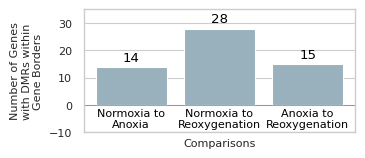

In [63]:
# PLOT
# Sample data
categories = number_of_transcripts.keys()
values = number_of_transcripts.values()

# Create a bar plot
sns.set_theme(palette = 'colorblind', style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})
plt.figure(figsize=((9.5/2.54), (4.25/2.54)))
plt.bar(categories, values, color='skyblue')
#plt.title("Differentially Methylated Regions (DMR) within Gene Borders")
plt.xlabel("Comparisons")
plt.ylabel("Number of Genes\nwith DMRs within\nGene Borders")

# Add labels to the bars
for i, value in enumerate(values):
    plt.text(i, value + 1, str(abs(value)), ha='center', va='bottom', color='black')

# change the color of the bars (first two: blue, second two: red, third two: green)
plt.bar(range(len(number_of_transcripts)), list(number_of_transcripts.values()), align='center', color='#99B1BD')

# y scale 
plt.ylim(-10, 35)
# remove x scale
plt.xticks([])

# add a label in the center of the first two bars 
plt.text(0, -5, 'Normoxia to\nAnoxia', ha='center', va='center', color='black', fontsize=8)
plt.text(1, -5, 'Normoxia to\nReoxygenation', ha='center', va='center', color='black', fontsize=8)
plt.text(2, -5, 'Anoxia to\nReoxygenation', ha='center', va='center', color='black', fontsize=8)


# add a 0 line 
# the line should be slim and grey
plt.axhline(y=0, color='grey', linestyle='-', linewidth=0.5)

plt.tight_layout()
# Save the figure as a high-quality image (e.g., PNG or PDF)
plt.savefig('7_match_dmr_to_gene/DMR_within_geneborders.svg')

# Show the plot
plt.show()


# 6) Location of DMR within Genes

In [64]:
# check if DMR are before or after gene start 
for subset_name, dmr_subset in dmr_withinGeneBorder.items():
    dmr_withinGeneBorder[subset_name]['dmr_before_gene'] =  dmr_subset['end'] < dmr_subset['start_0']
    dmr_withinGeneBorder[subset_name]['dmr_after_gene'] =  dmr_subset['start'] > dmr_subset['stop_0']
    dmr_withinGeneBorder[subset_name]['dmr_inside_gene'] =  (dmr_subset['start'] > dmr_subset['start_0']) & (dmr_subset['end'] < dmr_subset['stop_0'])
    dmr_withinGeneBorder[subset_name]['dmr_overlap_start'] =  (dmr_subset['start'] < dmr_subset['start_0']) & (dmr_subset['end'] < dmr_subset['stop_0'])
    dmr_withinGeneBorder[subset_name]['dmr_overlap_end'] =  (dmr_subset['start'] < dmr_subset['stop_0']) & (dmr_subset['end'] > dmr_subset['stop_0'])
    dmr_withinGeneBorder[subset_name]['dmr_overlap_both'] =  (dmr_subset['start'] < dmr_subset['start_0']) & (dmr_subset['end'] > dmr_subset['stop_0'])
    

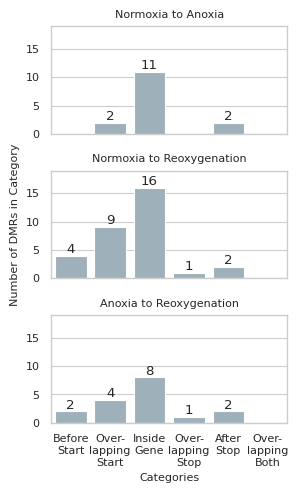

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})

# Define the x and y data for the bars
categories = ['Before\nStart', 'Over-\nlapping\nStart', 'Inside\nGene', 'Over-\nlapping\nStop', 'After\nStop', 'Over-\nlapping\nBoth']

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=((7.8/2.54), (12.75/2.54)), sharex=True, sharey=True)

# rename subplots 
names = {'NvsA': 'Normoxia to Anoxia', 'NvsR': 'Normoxia to Reoxygenation', 'AvsR': 'Anoxia to Reoxygenation'}

for i, (subset_name, dmr_subset) in enumerate(dmr_withinGeneBorder.items()): 
    values = [
        dmr_subset['dmr_before_gene'].sum(), 
        dmr_subset['dmr_overlap_start'].sum(), 
        dmr_subset['dmr_inside_gene'].sum(),
        dmr_subset['dmr_overlap_end'].sum(),
        dmr_subset['dmr_after_gene'].sum(), 
        dmr_subset['dmr_overlap_both'].sum()
    ]
    sns.barplot(
        ax=axs[i], 
        x=categories, 
        y=values,
        color='#99B1BD'
    )

    axs[i].set_title(f"{names[subset_name]}", fontsize=8)	
    axs[i].set_ylim(0, 19)
    
    # Annotate the bars with the values if value is not zero
    for j, value in enumerate(values):
        if value != 0:
            axs[i].text(
                j, 
                value, 
                f'{value}', 
                ha='center', 
                va='bottom'
            )

# Set the xlabel only on the last subplot
axs[-1].set_xlabel('Categories')
axs[1].set_ylabel("Number of DMRs in Category")


plt.tight_layout()

# export 
plt.savefig('7_match_dmr_to_gene/DMR_location_within_geneborders.svg')
plt.show()


# 7) How many DMR hit gene ids 

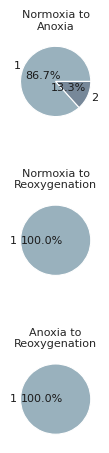

In [66]:
import matplotlib.pyplot as plt

# Create a figure and 3 subplots in a 3x1 grid
sns.set_theme(style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})
fig, axs = plt.subplots(3, 1, figsize=((3/2.54), (12.75/2.54)))

# Define the colors for the pie charts
colors = ['#99B1BD', 'lightslategray']

# rename subplots
names = {'NvsA': 'Normoxia to\nAnoxia', 'NvsR': 'Normoxia to\nReoxygenation', 'AvsR': 'Anoxia to\nReoxygenation'}

# Iterate over the dmr_withinGeneBorder items
for i, (subset_name, dmr_subset) in enumerate(dmr_withinGeneBorder.items()): 
    ax = axs[i]
    # Calculate the value counts
    value_counts = dmr_subset.groupby('gene_id')['gene_id'].transform('count').value_counts()
    # Plot the pie chart
    wedges, texts, autotexts = ax.pie(
        value_counts, 
        labels=value_counts.index, 
        autopct='%1.1f%%',
        textprops=dict(color="k", fontsize=8),
        colors=colors,
        pctdistance=0.4	
    )
    ax.set_title(f"{names[subset_name]}", fontsize=8)
    #ax.legend(wedges, value_counts.index, title="Counts", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Adjust subplot parameters
plt.tight_layout()
# Save the figure
plt.savefig('7_match_dmr_to_gene/DMRs_per_geneid_distribution.svg')
plt.show()


# 8) Correlate to DEGs

In [67]:
# import deg data from RNA pipeline 
deg_NvsA = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/deg_na.csv', sep=',')
deg_NvsR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/deg_nr.csv', sep=',')	
deg_AvsR = pd.read_csv('/home/maggy/WholeGenomeBisulphiteSequencing/RNAseq_pipeline/11_identify_DEG/deg_ar.csv', sep=',')
# select gene id column 
deg_na = set(deg_NvsA['Unnamed: 0'])
deg_nr = set(deg_NvsR['Unnamed: 0'])
deg_ar = set(deg_AvsR['Unnamed: 0'])

print(len(deg_na))
print(len(deg_nr))
print(len(deg_ar))

1265
580
462


In [68]:
# Correlation of DEG and DMR 
correlationNA = pd.DataFrame(deg_na.intersection(geneid_unique['NvsA']))
correlationNR = pd.DataFrame(deg_nr.intersection(geneid_unique['NvsR']))
correlationAR = pd.DataFrame(deg_ar.intersection(geneid_unique['AvsR']))

# 9) Venn diagram (DMR vs DEG) 

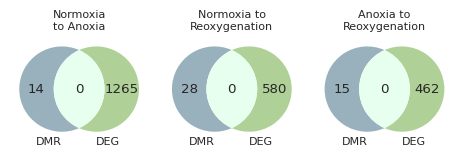

In [69]:
# Sample data for Venn diagrams
# DMS data
DMR_na = set(geneid_unique['NvsA'])
DMR_nr = set(geneid_unique['NvsR'])
DMR_ar = set(geneid_unique['AvsR'])
# DEG data 
DEG_na = deg_na
DEG_nr = deg_nr
DEG_ar = deg_ar

# Create a figure with three subplots
sns.set_theme(style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})
fig, axes = plt.subplots(1, 3, figsize=((12/2.54), (4.25/2.54)))

# Plot Venn diagrams in each subplot
v1 = venn2_unweighted([DMR_na, DEG_na], set_labels=('DMR', 'DEG'), ax=axes[0], alpha=1, set_colors=('#99B1BD','#AFD198'), normalize_to=1.0)
v2 = venn2_unweighted([DMR_nr, DEG_nr], set_labels=('DMR', 'DEG'), ax=axes[1], alpha=1, set_colors=('#99B1BD','#AFD198'), normalize_to=1.0)
v3 = venn2_unweighted([DMR_ar, DEG_ar], set_labels=('DMR', 'DEG'), ax=axes[2], alpha=1, set_colors=('#99B1BD','#AFD198'), normalize_to=1.0)
v = [v1, v2, v3]
for element in v: 
    for text in element.set_labels:
        text.set_fontsize(8)


# add titles to the subplots
axes[0].set_title('Normoxia\nto Anoxia', fontsize=8)
axes[1].set_title('Normoxia to\nReoxygenation', fontsize=8)
axes[2].set_title('Anoxia to\nReoxygenation', fontsize=8)

# Add titles in center 
#fig.suptitle('Differentially Methylated Regions (DMR) vs Differentially Expressed Genes (DEG)', fontsize=16)
plt.tight_layout()
# Save the figure as a high-quality image (e.g., PNG or PDF)
plt.savefig('7_match_dmr_to_gene/DMR_vs_DEG_venn.svg')

# Show the plot
plt.show()


# 10) DMR functional annotation 

In [70]:
# Import go terms and description 
# Geneid to GO term
goterm = pd.read_csv('9_DMR_functional_annotation/ccar2swissprotGO_long.txt', sep='\t')
goterm['GO_id'] = goterm['GO_id'].str.strip()

# GO term to description
godesc = pd.read_csv('9_DMR_functional_annotation/go_data.txt', sep='\t')
godesc['id'] = godesc['id'].str.strip()


In [71]:
#create pandas series for gene_id and goterm
go_map = goterm.set_index('gene_id')['GO_id'].str.strip()

# define a function to select the right go term for each gene id
def select(geneid): 
    temp = go_map.get(geneid,default=pd.Series())
    if isinstance(temp, pd.Series):
        return temp.tolist()
    else:
        return [temp]

# create empty dict
functional_annotation = {}

# append go term to dmr_withinGeneBorder
for name,df in dmr_withinGeneBorder.items():
    df = df.drop_duplicates(subset=['gene_id'])
    df['goterm'] = df['gene_id'].apply(select)
    df = df.explode('goterm').dropna(subset=['goterm'])
    df[[ 'description', 'biofunction']] = godesc.set_index('id').loc[df ['goterm']].to_numpy()
    functional_annotation[name] = df.sort_values('biofunction')

# export the go terms for GO enrichment analysis 
for name, df in functional_annotation.items():
    df['gene_id'].to_csv(f'9_DMR_functional_annotation/{name}_functional_annotation.csv', index=False)

/tmp/ipykernel_24649/1984297226.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['goterm'] = df['gene_id'].apply(select)


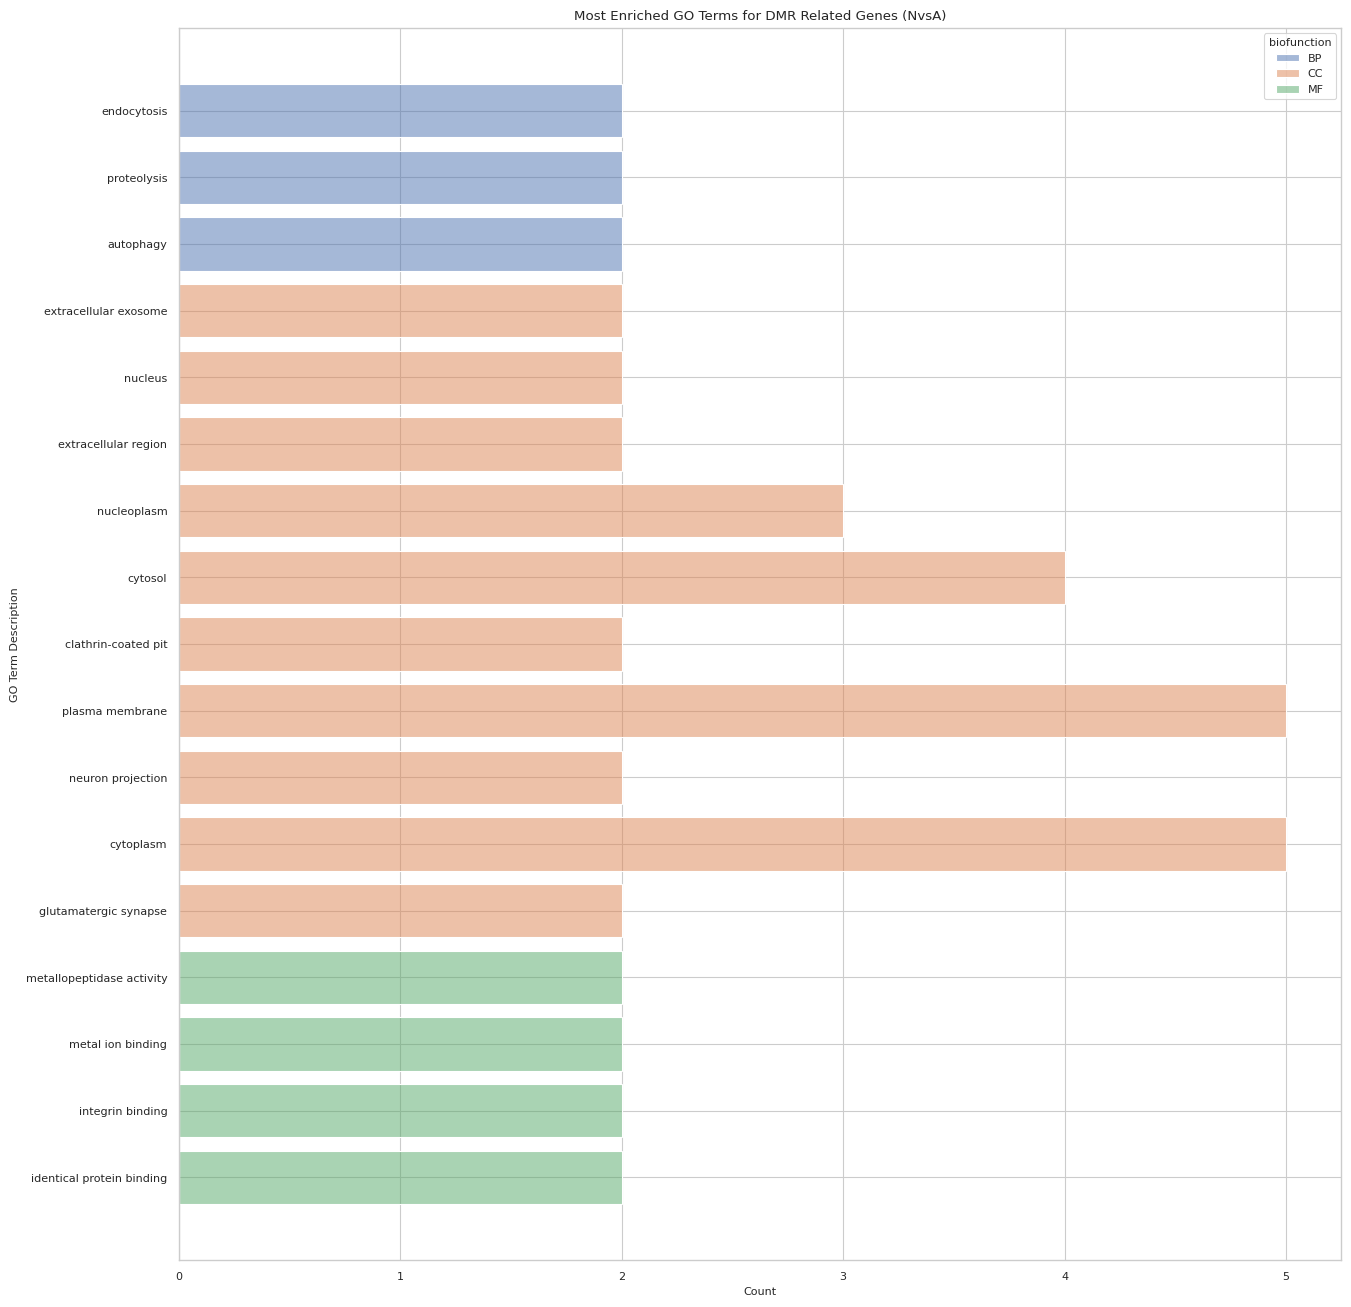

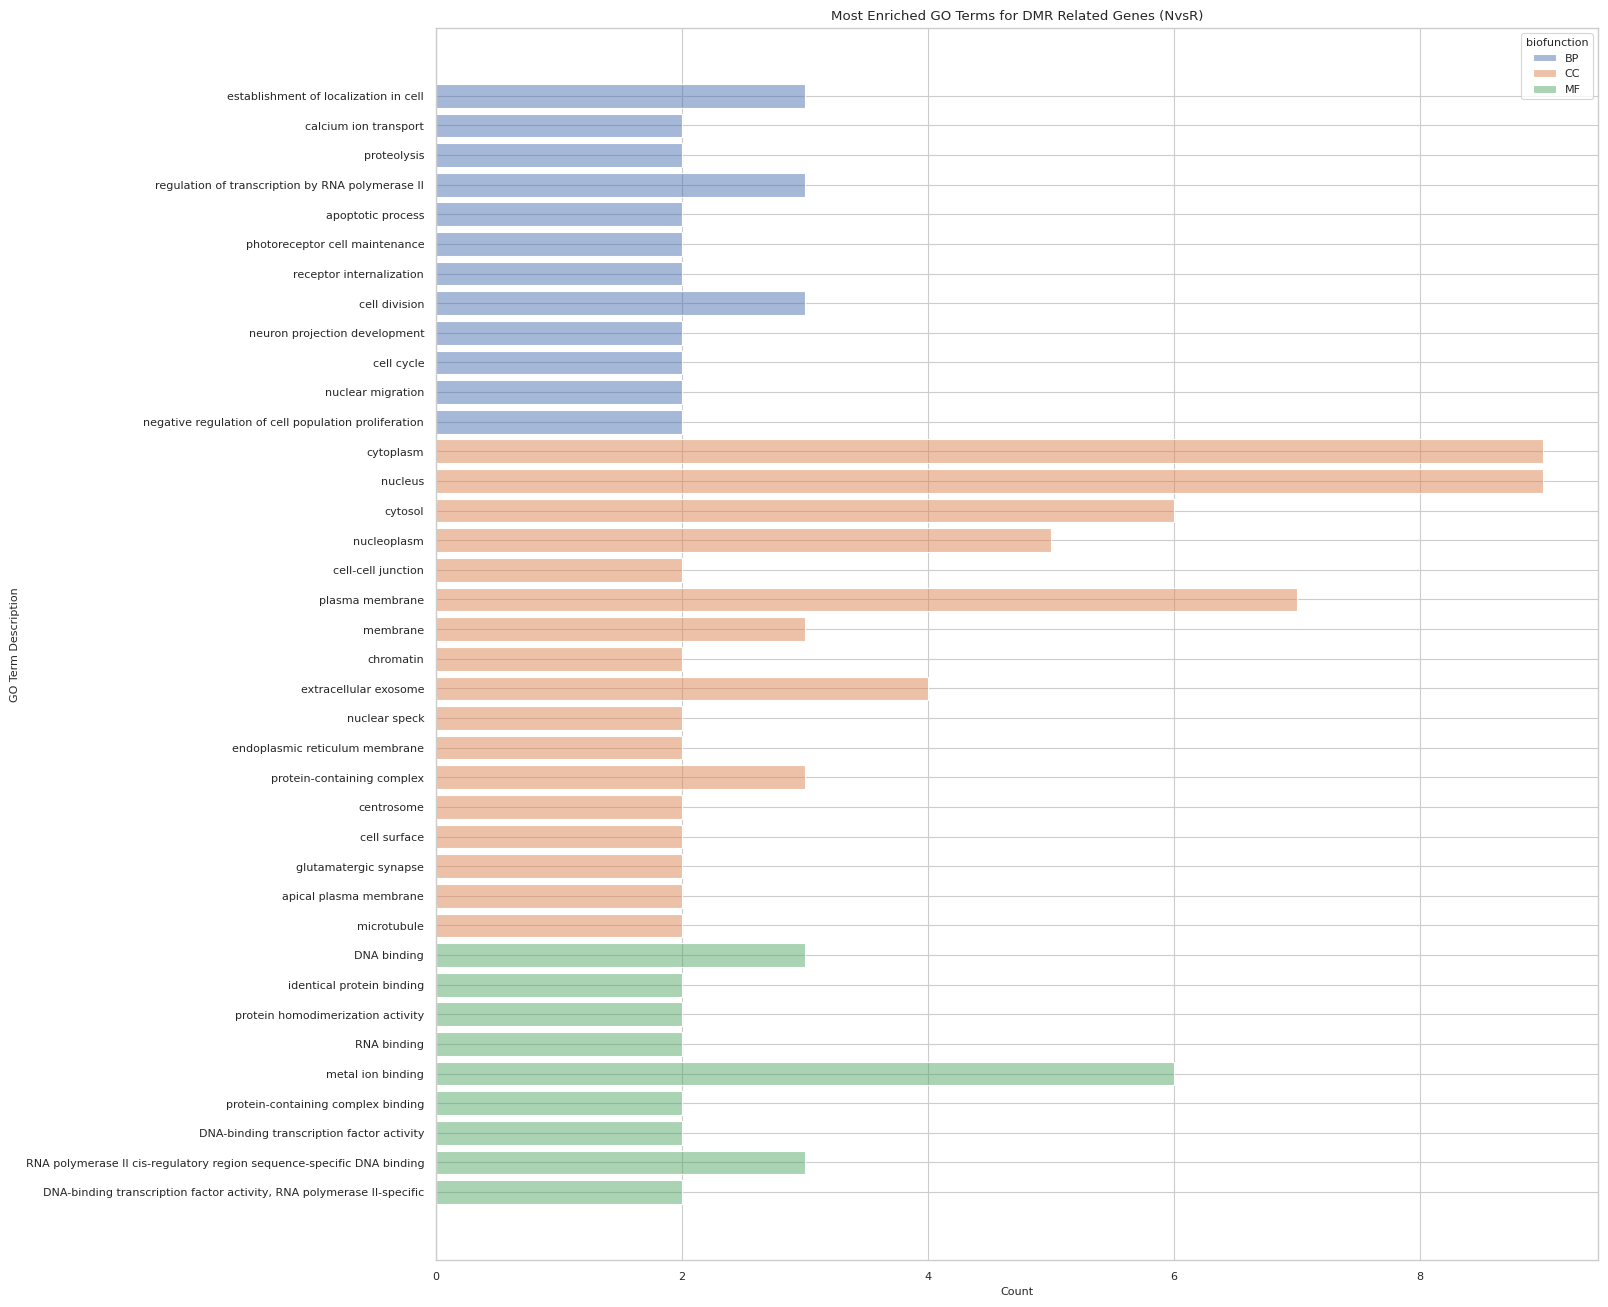

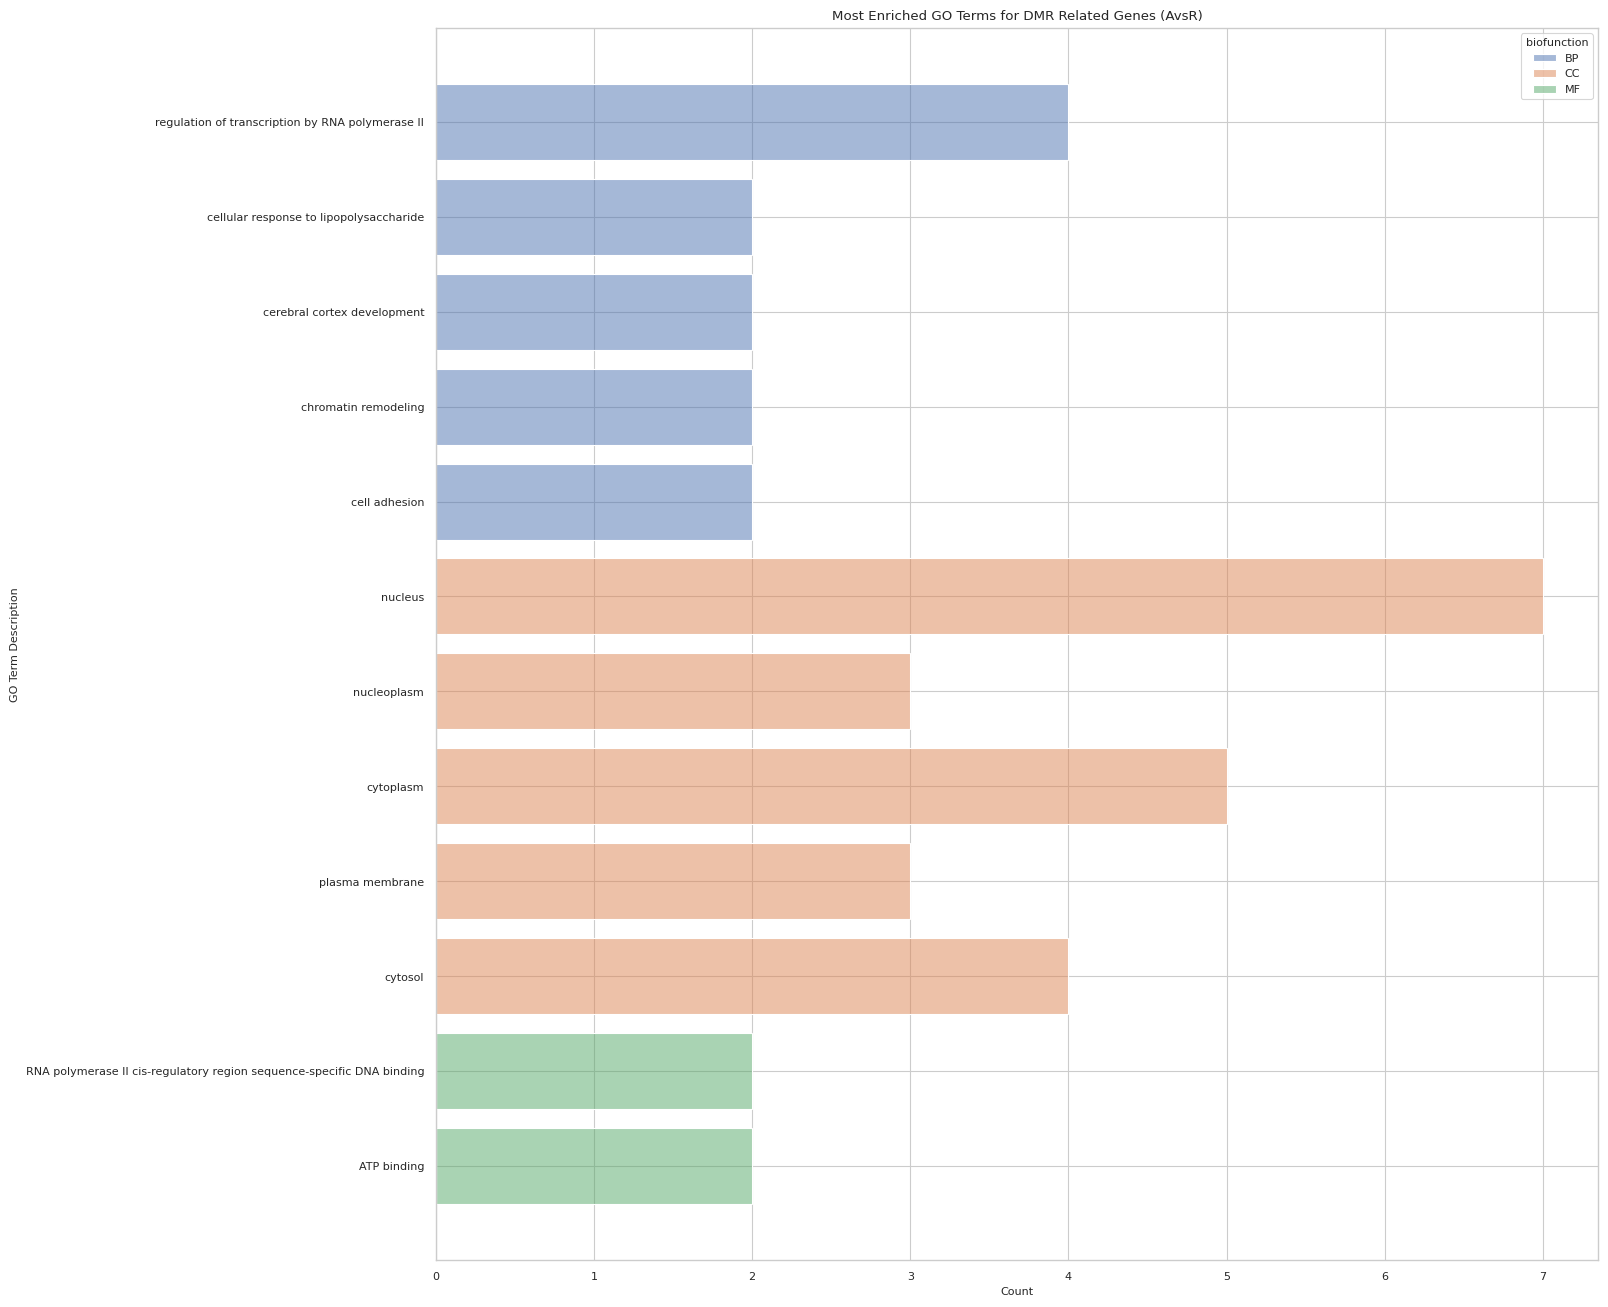

In [72]:
#PLOT
# for plot filter the dataframes to only plot the GO terms that are hit multiple times 
functional_annotation_plot = {}
for name, df in functional_annotation.items():
    df = df.groupby('goterm').filter(lambda x: len(x) > 1)
    functional_annotation_plot[name] = df

#create histogram 
for name, df in functional_annotation_plot.items():
    fig,ax = plt.subplots(figsize=(15, 16))
    sns.histplot(data=df, y='description', hue='biofunction', shrink=0.8, discrete=True)
    plt.title(f'Most Enriched GO Terms for DMR Related Genes ({name})')
    plt.ylabel('GO Term Description')
    plt.savefig(f'7_match_dmr_to_gene/GO_terms_{name}.png', dpi=500, bbox_inches='tight')


# 9) investigate hyper- and hypomethlyation

In [73]:
# filter the input dmr files to only keep the dmrs that are within gene border 
# create dict 
select = {}

for name, df in dmr_withinGeneBorder.items():
    select[name] = df.index.unique().tolist()
    
import json 
with open ('7_match_dmr_to_gene/select_lines.json', 'w') as file:
    json.dump(select, file)

In [74]:


for name, input_file in input_files.items():
    # read inputfiles (function is defined above)
    array = read_methylscore(input_file)
    array = array[select[name]]
    with open (f'7_match_dmr_to_gene/dmr_withingene_{name}.txt', 'w') as file:
        for line in array:
            file.write('\t'.join(line) + '\n')




# 10) Investigate where DMR within gene 

In [75]:
for name, df in dmr_withinGeneBorder.items():
    df['start_std'] = (df['start'] - df['start_5']) / (df['stop_5'] - df['start_5'])
    df['end_std'] = (df['end'] - df['start_5']) / (df['stop_5'] - df['start_5'])

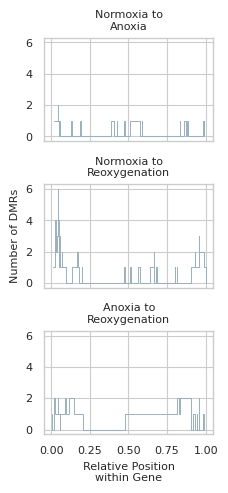

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a figure and 3 subplots in a 3x1 grid, sharing the x-axis
sns.set_theme(style = 'whitegrid', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8})
fig, axs = plt.subplots(3, 1, figsize=((6/2.54), (12.75/2.54)), sharex=True, sharey=True)

# rename subplots
names = {'NvsA': 'Normoxia to\nAnoxia', 'NvsR': 'Normoxia to\nReoxygenation', 'AvsR': 'Anoxia to\nReoxygenation'}

# Iterate over the dmr_withinGeneBorder items
for i, (name, df) in enumerate(dmr_withinGeneBorder.items()):
    # Prepare the data for the step plot
    starts = pd.Series({i: 1 for i in df['start_std']})
    stops = pd.Series({i: -1 for i in df['end_std']})
    all = pd.concat([starts, stops]).sort_index()
    all.index.name = 'position'
    coverage = all.groupby('position').sum().cumsum()

    # Plot the step plot on the respective subplot
    ax = axs[i]
    ax.step(coverage.index, coverage, where='post', color='#99B1BD', linewidth=0.7)
    ax.set_title(f'{names[name]}', fontsize=8)


# Set the x-label only on the last subplot
axs[-1].set_xlabel('Relative Position\nwithin Gene')
axs[1].set_ylabel("Number of DMRs")

# Adjust subplot parameters
plt.tight_layout()
# export 
plt.savefig('7_match_dmr_to_gene/DMR_coverage_within_geneborders.svg')
plt.show()


# 11 Invesigate which DMR belongs to which gene 

In [77]:



# import differentially expressed DMR genes 
sigdmr = pd.read_csv('13_protein_sequence/13_sig_TMM_protein_seq.tsv', sep='\t', header=None)
sigdmr = sigdmr[0].to_list()

In [78]:
dmr_withinGeneBorder['NvsA'].loc[dmr_withinGeneBorder['NvsA']['gene_id'].isin(sigdmr)]

,chr,start,end,gene_id,start_5,stop_5,start_0,stop_0,dmr_before_gene,dmr_after_gene,dmr_inside_gene,dmr_overlap_start,dmr_overlap_end,dmr_overlap_both,start_std,end_std
1,ccar_ua02,27087438,27087561,ccar_ua02-g2350,27087366,27091480,27087553,27091293,False,False,False,True,False,False,0.017501,0.047399
10,ccar_ua15,4461803,4461996,ccar_ua15-g14343,4460616,4488773,4461896,4487494,False,False,False,True,False,False,0.042156,0.049011
26,ccar_ub15,4988609,4988761,ccar_ub15-g36855,4987910,5001981,4988550,5001342,False,False,True,False,False,False,0.049677,0.060479


In [79]:
test = dmr_withinGeneBorder['NvsR'].loc[dmr_withinGeneBorder['NvsR']['gene_id'].isin(sigdmr)]
test.drop(columns=['start_5', 'stop_5', 'start_0', 'stop_0'], inplace=True)

/tmp/ipykernel_24649/3377399388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(columns=['start_5', 'stop_5', 'start_0', 'stop_0'], inplace=True)


In [80]:
test

,chr,start,end,gene_id,dmr_before_gene,dmr_after_gene,dmr_inside_gene,dmr_overlap_start,dmr_overlap_end,dmr_overlap_both,start_std,end_std
2,ccar_ua02,11254797,11254956,ccar_ua02-g1919,False,False,True,False,False,False,0.563053,0.572897
4,ccar_ua05,1044214,1044282,ccar_ua05-g5120,False,True,False,False,False,False,0.95546,0.958941
11,ccar_ua12,344631,344738,ccar_ua12-g11671,False,False,True,False,False,False,0.067264,0.072623
12,ccar_ua14,7196453,7196576,ccar_ua14-g13591,False,False,False,True,False,False,0.044159,0.0479
14,ccar_ua15,5261594,5261669,ccar_ua15-g14373,False,False,True,False,False,False,0.798389,0.802096
15,ccar_ua15,11022989,11023466,ccar_ua15-g14605,False,False,True,False,False,False,0.636912,0.667834
30,ccar_ub01,14678946,14679265,ccar_ub01-g23719,False,False,True,False,False,False,0.513024,0.517419
33,ccar_ub03,26889492,26889808,ccar_ub03-g26528,False,False,True,False,False,False,0.136897,0.175112
36,ccar_ub05,13978362,13978778,ccar_ub05-g28395,True,False,False,True,False,False,0.026534,0.032126
40,ccar_ub11,23824862,23825048,ccar_ub11-g34058,False,False,True,False,False,False,0.663488,0.66857


In [81]:
dmr_withinGeneBorder['AvsR'].loc[dmr_withinGeneBorder['AvsR']['gene_id'].isin(sigdmr)]

,chr,start,end,gene_id,start_5,stop_5,start_0,stop_0,dmr_before_gene,dmr_after_gene,dmr_inside_gene,dmr_overlap_start,dmr_overlap_end,dmr_overlap_both,start_std,end_std
0,ccar_ua02,27087438,27087561,ccar_ua02-g2350,27087366,27091480,27087553,27091293,False,False,False,True,False,False,0.017501,0.047399
1,ccar_ua05,9401931,9401987,ccar_ua05-g5369,9396474,9402419,9396745,9402149,False,False,True,False,False,False,0.917914,0.927334
